# Initialisations

In [93]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import anndata
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import median_abs_deviation

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

import anndata2ri
import logging
import matplotlib.pyplot as plt

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/var/folders/gv/57z5thfs7kqfq2njhk1gg9jc0000gn/T/ipykernel_5129/3927587813.py:25: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [94]:
adata = sc.read_h5ad('epi_adata.h5ad')

In [95]:
adata.layers["counts"] = adata.X

In [96]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 489 × 25815
    obs: 'cell_ids', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_symbols', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

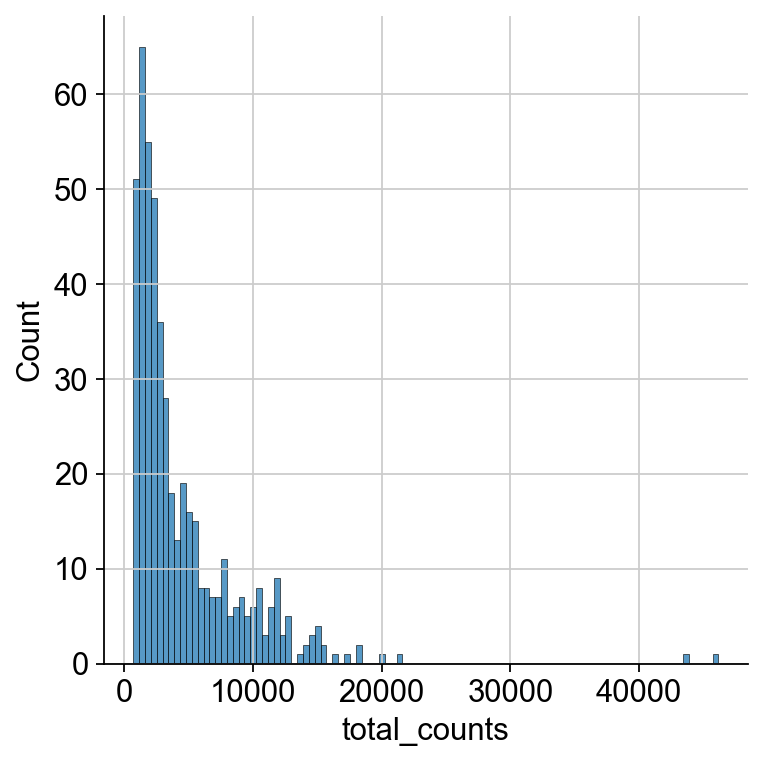

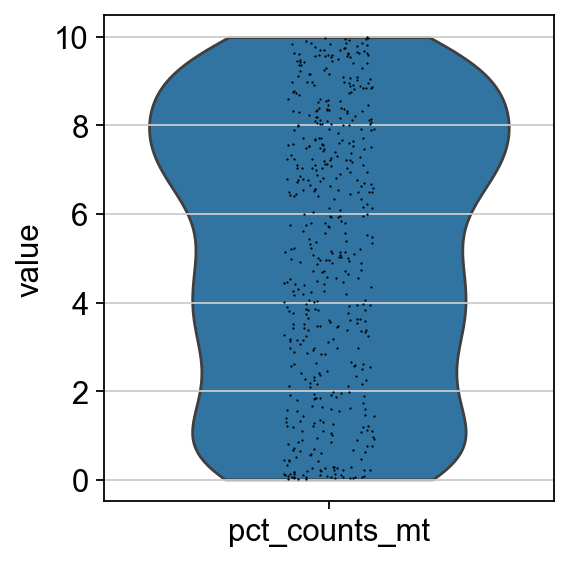

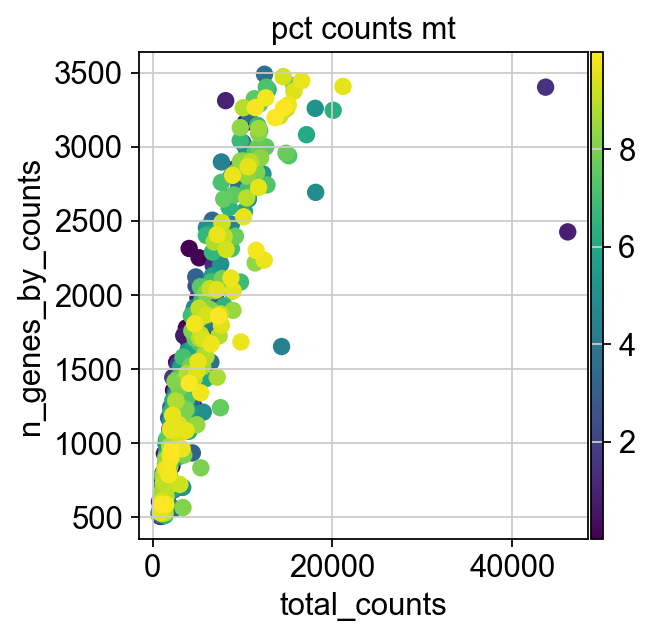

In [97]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

####looks lile pre=processing based on % mt counts has also been done

# Normalisation

In [98]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

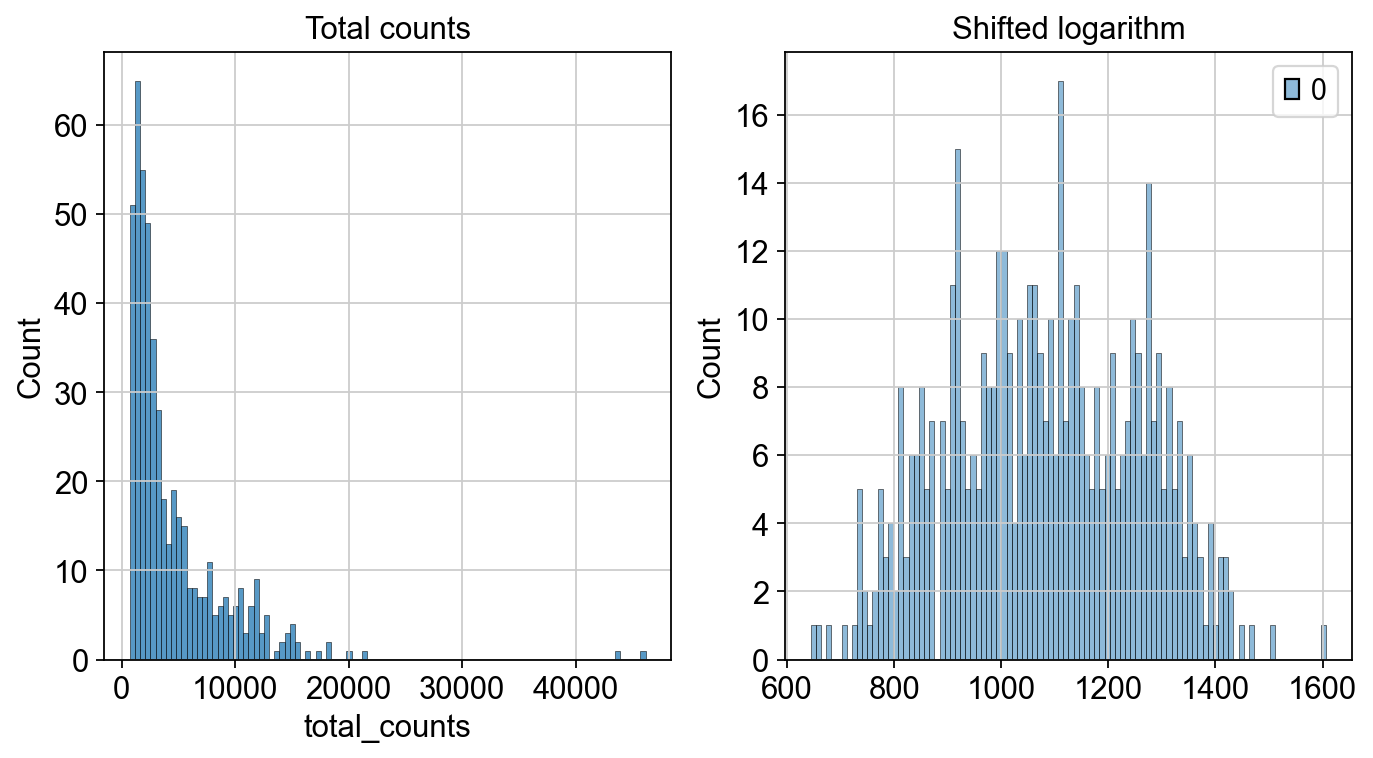

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs['total_counts'], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

In [100]:
from scipy.sparse import csr_matrix, issparse

In [101]:
%%R
library(scran)
library(BiocParallel)

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOr

In [102]:
# Preliminary clustering for differentiated normalisation
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

/var/folders/gv/57z5thfs7kqfq2njhk1gg9jc0000gn/T/ipykernel_5129/2214793430.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_pp, key_added="groups")


In [103]:
data_mat = adata_pp.X.T
# convert to CSC if possible. See https://github.com/MarioniLab/scran/issues/70
if issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()
ro.globalenv["data_mat"] = data_mat
ro.globalenv["input_groups"] = adata_pp.obs["groups"]

In [104]:
del adata_pp

In [105]:
%%R -o size_factors

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam()
    )
)

In [106]:
adata.obs["size_factors"] = size_factors
scran = adata.X / adata.obs["size_factors"].values[:, None]
adata.layers["scran_normalization"] = csr_matrix(sc.pp.log1p(scran))

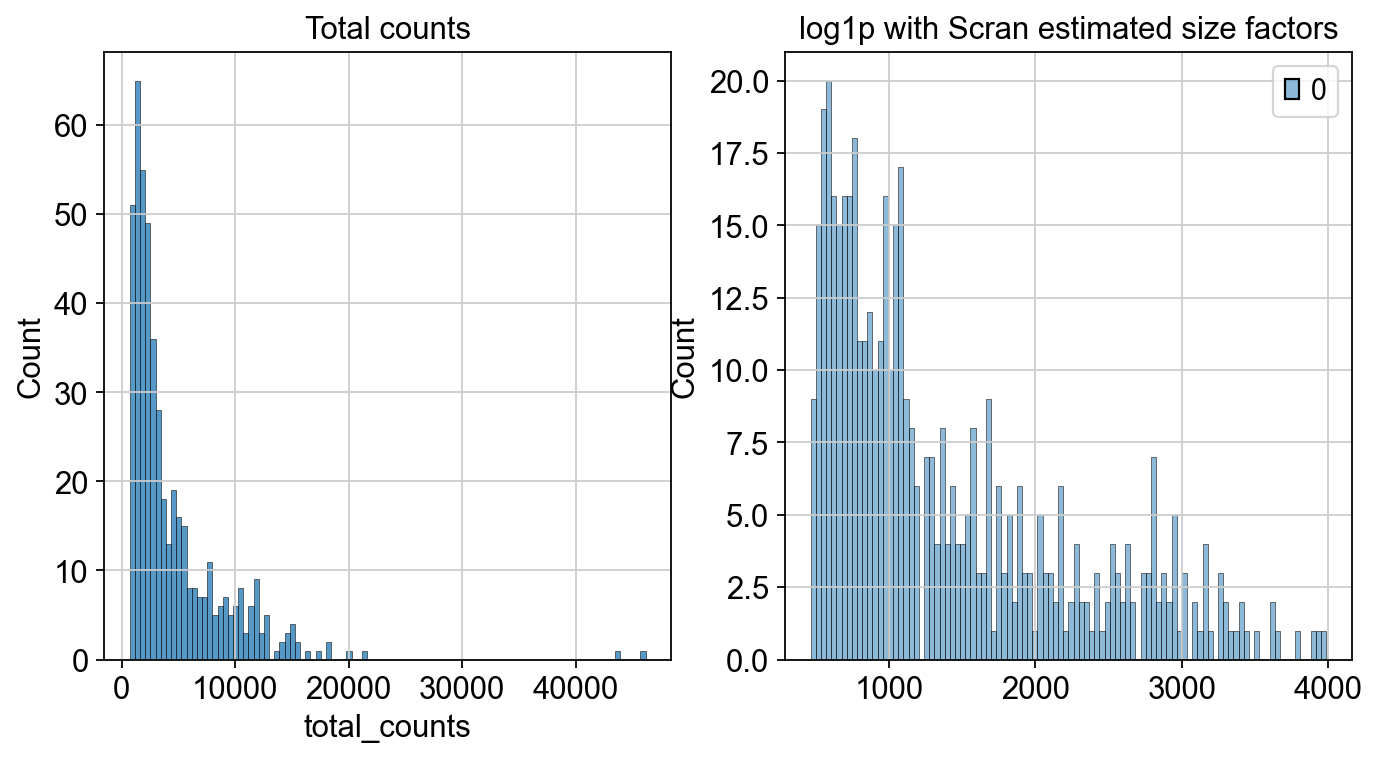

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["scran_normalization"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("log1p with Scran estimated size factors")
plt.show()

# Feature selection

currently generate both highly variable (on log1pnorm counts) and highly deviant on raw counts.

In [108]:
%%R -i adata
library(scry)

In [109]:
ro.globalenv["adata"] = adata

In [110]:
%%R
sce = devianceFeatureSelection(adata, assay="X")

In [111]:
binomial_deviance = ro.r("rowData(sce)$binomial_deviance").T

In [112]:
idx = binomial_deviance.argsort()[-8000:]
mask = np.zeros(adata.var_names.shape, dtype=bool)
mask[idx] = True

adata.var["highly_deviant"] = mask
adata.var["binomial_deviance"] = binomial_deviance

adata

AnnData object with n_obs × n_vars = 489 × 25815
    obs: 'cell_ids', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'size_factors'
    var: 'gene_symbols', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_deviant', 'binomial_deviance'
    layers: 'counts', 'log1p_norm', 'scran_normalization'

In [113]:
sc.pp.highly_variable_genes(adata, layer="log1p_norm")
adata

AnnData object with n_obs × n_vars = 489 × 25815
    obs: 'cell_ids', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'size_factors'
    var: 'gene_symbols', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm', 'scran_normalization'

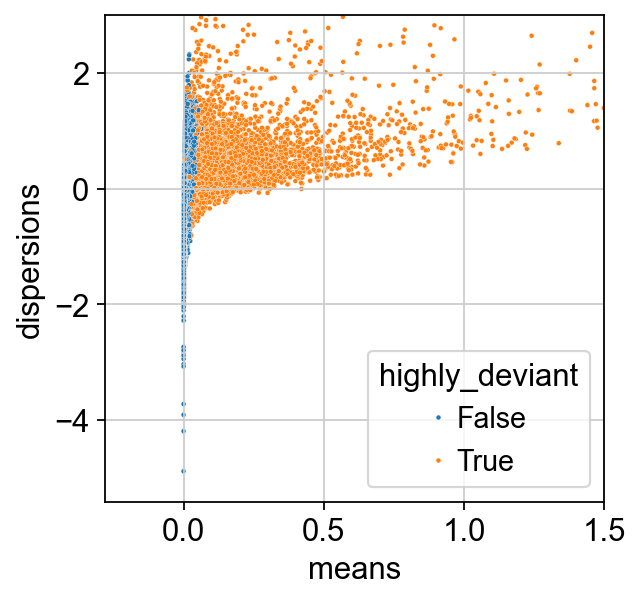

In [114]:
ax = sns.scatterplot(
    data=adata.var, x="means", y="dispersions", hue="highly_deviant", s=5
)
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)
plt.show()

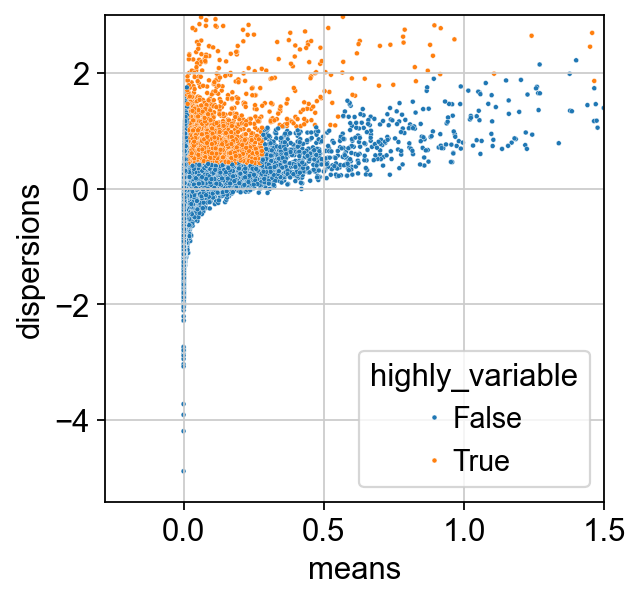

In [115]:
ax = sns.scatterplot(
    data=adata.var, x="means", y="dispersions", hue="highly_variable", s=5
)
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)
plt.show()

# DIM reduction

Based on highly deviant

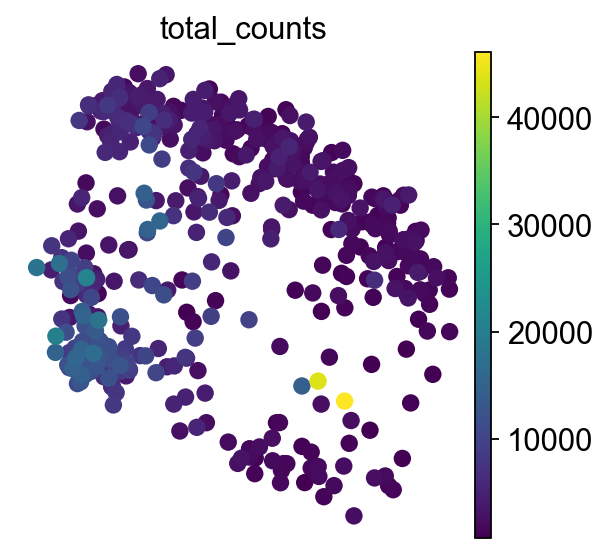

In [116]:
## Choose normalisation

sc.pp.pca(adata, layer = "log1p_norm", svd_solver="arpack", mask_var = "highly_deviant")
#sc.pp.pca(adata, layer = "scran_normalization", svd_solver="arpack", mask_var = "highly_deviant")

sc.pl.pca_scatter(adata, color="total_counts")

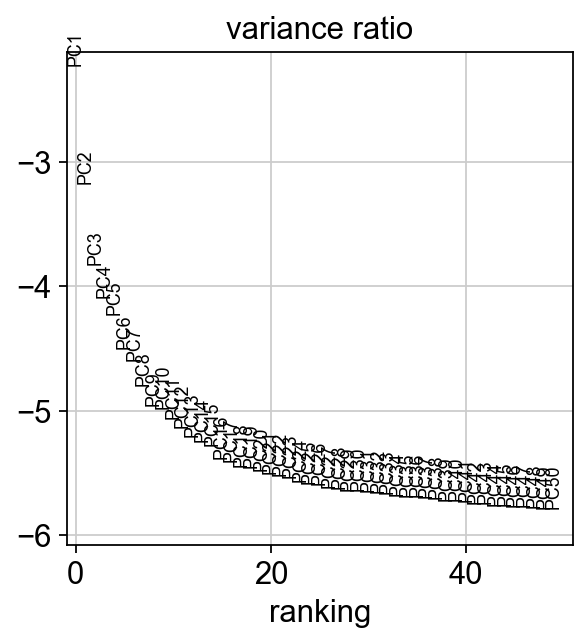

In [117]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

Based on highly variable

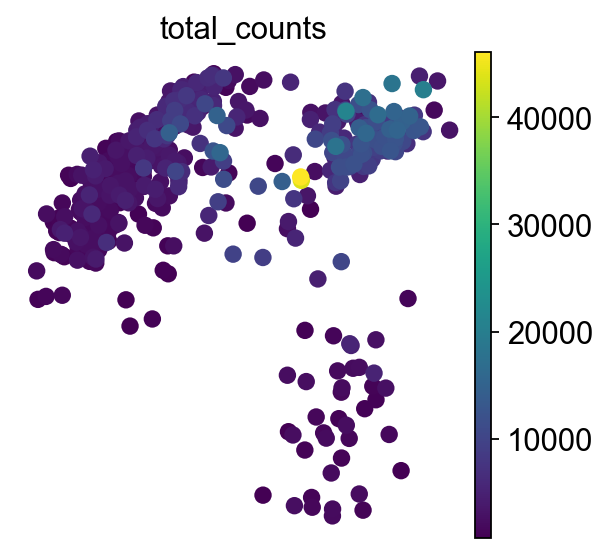

In [118]:
#Log 1p achieved much better separation here
sc.pp.pca(adata, layer = "log1p_norm", svd_solver="arpack", mask_var = "highly_variable")

#sc.pp.pca(adata, layer = "scran_normalization", svd_solver="arpack", mask_var = "highly_variable")
sc.pl.pca_scatter(adata, color="total_counts")

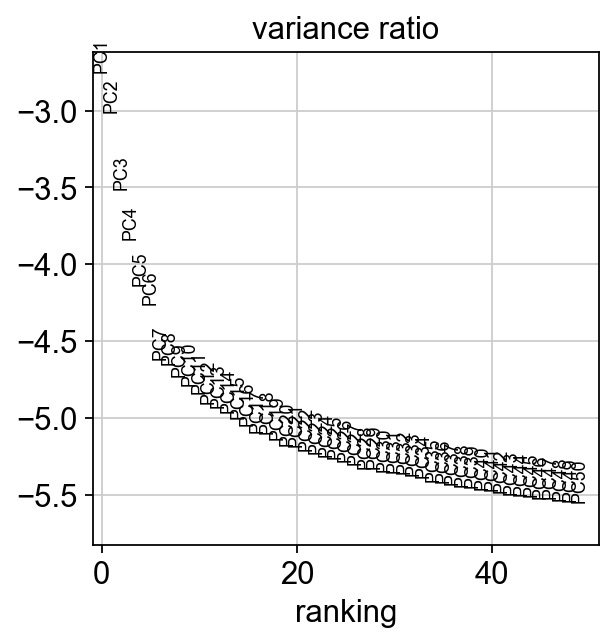

In [119]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

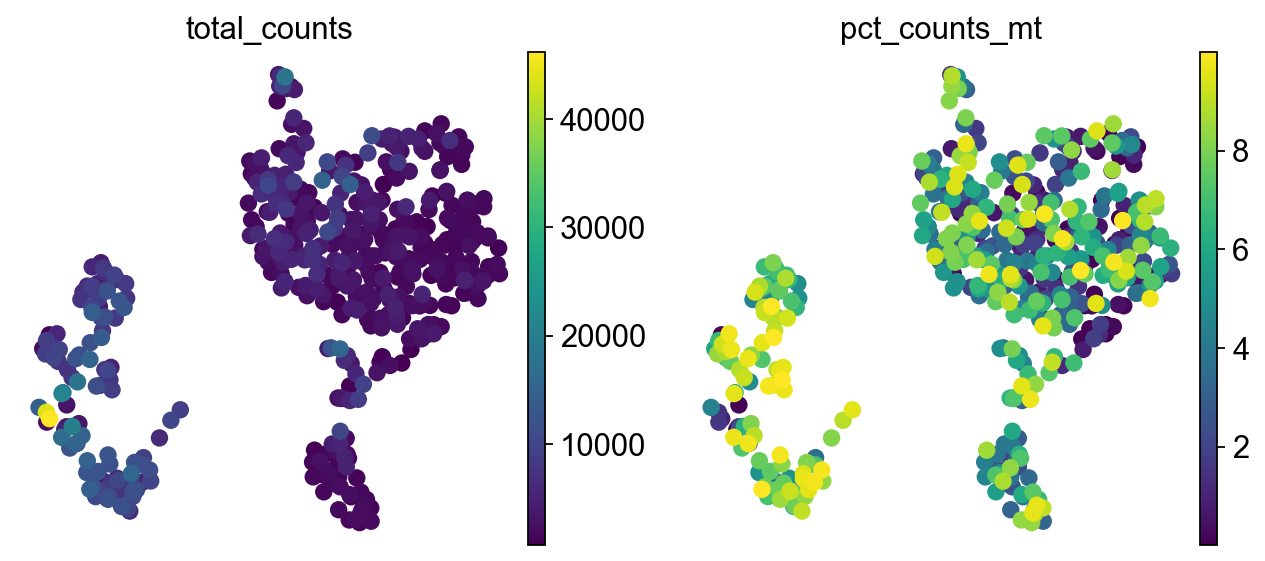

In [120]:
#50 vs 20 relatively similar (on UMAP) - went with 50 due to apparently low conseuqence of using too many

sc.pp.neighbors(adata, n_pcs=50)
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=["total_counts", "pct_counts_mt"],
)

# Clustering

In [121]:
# calcualted off PC space defined in DIM reduction above - highly variable/deviant and type of normalisation are defined there

sc.pp.neighbors(adata, n_pcs=50)
sc.tl.umap(adata)

In [122]:
sc.tl.leiden(adata, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata, key_added="leiden_res0_4", resolution=0.4)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res0_6", resolution=0.6)
sc.tl.leiden(adata, key_added="leiden_res0_7", resolution=0.7)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)

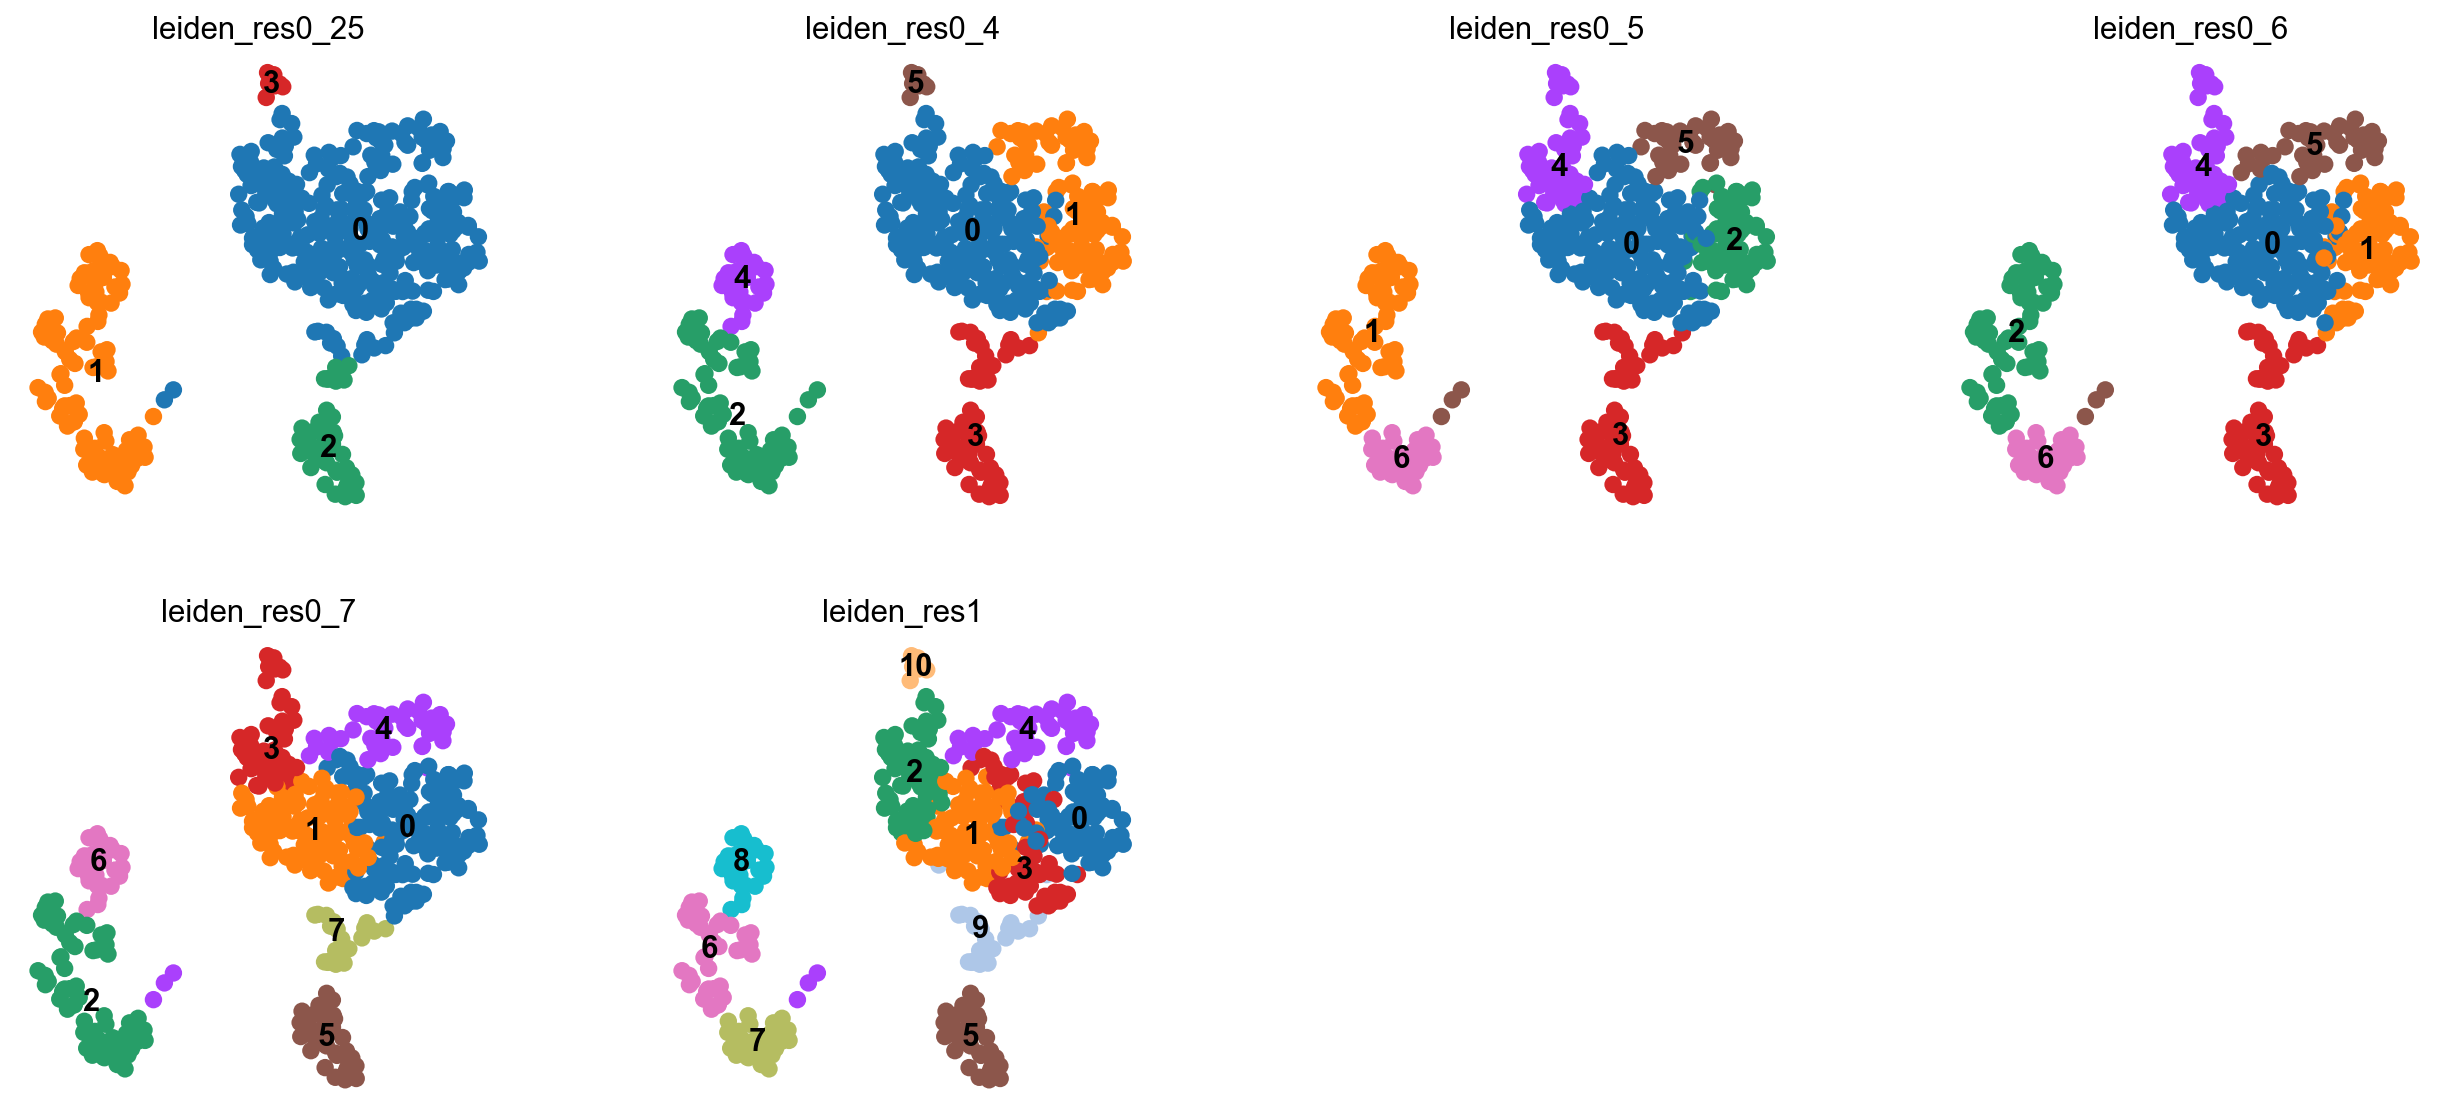

In [123]:
sc.pl.umap(
    adata,
    color=["leiden_res0_25", "leiden_res0_4", "leiden_res0_5", "leiden_res0_6", "leiden_res0_7","leiden_res1"],
    legend_loc="on data", 
)

# visually hard to tell how many clusters make sense, data paper found 6 using their DEG metric, will use DEG chart and dendrograms to inform

# Annotation

In [124]:
from math import isnan

## Labelling as malignant from SCEVAN

In [125]:
SCEVAN_results = pd.read_csv('SCEVAN_results.csv', header=None)

In [126]:
SCEVAN_results = SCEVAN_results.drop(0)

In [127]:
SCEVAN_results = SCEVAN_results[[0,1,3]]

In [128]:
print(SCEVAN_results)

                         0         1    3
1     AAACGCTTCATCTACT.1_1     tumor    1
2     AACCATGTCGAATGCT.1_1     tumor    1
3     ACATCCCAGTGCAAAT.1_1     tumor    1
4     ACCGTTCTCCTATGGA.1_1  filtered  NaN
5     ATCGCCTTCCATACAG.1_1     tumor    1
..                     ...       ...  ...
485  AGCCAATAGACATAGT.1_10    normal  NaN
486  ATTACCTTCGATCCCT.1_10    normal  NaN
487  CCCTTAGAGCTTCATG.1_10    normal  NaN
488  GACCAATGTATGGGAC.1_10    normal  NaN
489  GTTCGCTTCGGAGTGA.1_10     tumor    1

[489 rows x 3 columns]


In [129]:
type(1)

int

In [130]:
# create mapping dictionary - cell ID matched to tumoural status and subclone (if tumoural)
tum_dict = {}
clone_dict = {}

for i in range(1, SCEVAN_results.shape[0]):
    cellID = SCEVAN_results.loc[i][0]
    tum_type = SCEVAN_results.loc[i][1]

    #non tumoural sublcones set to 0
    if SCEVAN_results.loc[i][3] == 'NaN':
        subclone = 0
    else:
        subclone = SCEVAN_results.loc[i][3]
    #print(SCEVAN_results.loc[i][0])
    #print(SCEVAN_results.loc[i][1])
    tum_dict[cellID] = tum_type
    clone_dict[cellID] = subclone


print(tum_dict)
print(clone_dict)

{'AAACGCTTCATCTACT.1_1': 'tumor', 'AACCATGTCGAATGCT.1_1': 'tumor', 'ACATCCCAGTGCAAAT.1_1': 'tumor', 'ACCGTTCTCCTATGGA.1_1': 'filtered', 'ATCGCCTTCCATACAG.1_1': 'tumor', 'ATTTCACGTCCTACGG.1_1': 'normal', 'CATAAGCGTACGCTAT.1_1': 'tumor', 'CATGAGTTCTCAGTCC.1_1': 'tumor', 'CCACACTGTGGCTTAT.1_1': 'normal', 'CTAGACACACAGCTTA.1_1': 'tumor', 'CTATAGGCAGTCGTTA.1_1': 'normal', 'CTCATCGCACATTACG.1_1': 'filtered', 'CTGCCATAGGGTTAAT.1_1': 'tumor', 'GACCAATTCGCAACAT.1_1': 'tumor', 'GGTGTTAAGCAACTTC.1_1': 'tumor', 'GTCACGGAGCTAAATG.1_1': 'tumor', 'GTTTACTTCAGCCCAG.1_1': 'tumor', 'TACATTCGTAAGGCTG.1_1': 'tumor', 'TCGATTTAGCGGATCA.1_1': 'filtered', 'TGCGGCACAATTCTTC.1_1': 'tumor', 'TGGAGAGCAGCCGTTG.1_1': 'tumor', 'TTTCACAGTCATGGCC.1_1': 'tumor', 'AAAGAACTCAGCTCTC.1_2': 'filtered', 'AAGTTCGGTTAGAGTA.1_2': 'normal', 'AATGAAGGTTGCTAGT.1_2': 'normal', 'ACGATGTCACAGCATT.1_2': 'filtered', 'ACGGTCGTCGATTCCC.1_2': 'normal', 'ACTGATGAGGGTCAAC.1_2': 'normal', 'ACTGTCCAGATGAAGG.1_2': 'normal', 'AGATAGATCGGCTGAC.1

In [131]:
adata.obs.cell_ids

17        AAACGCTTCATCTACT.1_1
143       AACCATGTCGAATGCT.1_1
465       ACATCCCAGTGCAAAT.1_1
567       ACCGTTCTCCTATGGA.1_1
1433      ATCGCCTTCCATACAG.1_1
                 ...          
49096    AGCCAATAGACATAGT.1_10
49446    ATTACCTTCGATCCCT.1_10
49849    CCCTTAGAGCTTCATG.1_10
50484    GACCAATGTATGGGAC.1_10
51278    GTTCGCTTCGGAGTGA.1_10
Name: cell_ids, Length: 489, dtype: object

In [132]:
adata.obs["tumoural"] = adata.obs.cell_ids.map(tum_dict)
adata.obs["subclone"] = adata.obs.cell_ids.map(clone_dict)

In [133]:
adata.obs['tumoural'].value_counts()

tumor       228
filtered    141
normal      119
Name: tumoural, dtype: int64

In [134]:
adata.obs['subclone'].value_counts()

1    75
2    62
4    49
3    42
Name: subclone, dtype: int64

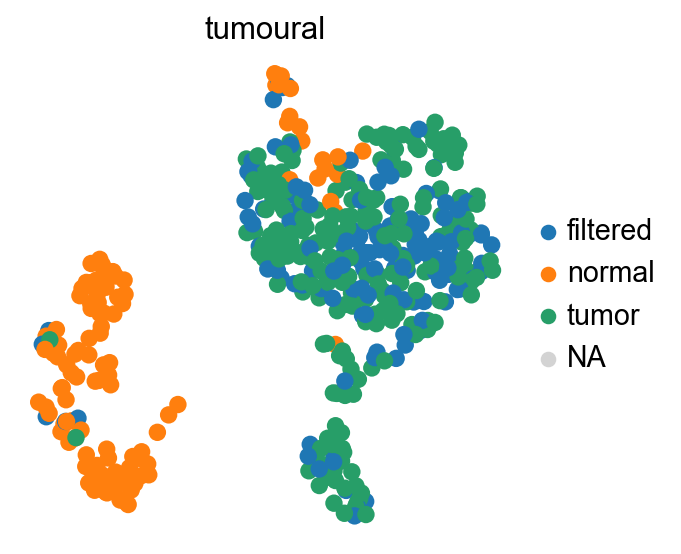

In [135]:
sc.pp.neighbors(adata, n_pcs=50)
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=["tumoural"],
)

## Standard annotation

In [136]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import celltypist ## don't use in final
from celltypist import models

import urllib.request

In [137]:
marker_genes = {
    "T-cell": ["CD3D", "IL7R", "CD2", "TRBC2", "TRBC1", "IL32"],
    "NK" : ["GNLY", "NKG7", "GZMB", "KLRD1", "PRF1", "GZMA"],
    "B-cell": ["MS4A1", "HLA-DRA", "BANK1", "CD79A", "CD83", "HLA-DQB1"],
    "Fibroblast": ["DCN", "CFD", "FBLN1", "LUM", "COL3A1", "COL1A2"],
    "Endothelial": ["PECAM1", "ACKR1", "TM4SF1", "AQP1", "IFI27", "EMP1", "CLDN5"],
    "Plasmablast": ["IGKC", "IGLC3", "IGLC2", "IGHA1", "IGHG4", "IGHG3"],
    "Myeloid": ["LYZ", "S100A9", "CXCL8", "IL1B", "S100A8", "EREG"],
    "Mast": ["TPSAB1", "TPSB2", "CPA3", "LTC4S", "MS4A2", "HDC"],
    "Myofibroblast": ["RGS5", "TAGLN", "MT1A", "MT1M", "C11orf96"],
    "Epithelial": ["EPCAM", "KRT8", "ELF3", "AGR2", "KRT19", "CLDN4", "KRT18"],
    "Adenocarcinoma": ['MUC1', "AGR2"],
    "Epithelia-Stem":['KRT15', "COL17A1"],
    "Cycling": ["MKI67", "STMN1", "TYMS", "TOP2A", "PCLAF", "CENPF", "ITGAE", "ENTPD1"],
    "Paper-Clusters": ["ATP5F1E", "PLCG2", "CSKMT", "S100A2", "PIGR", "MUC1", "GAPDH"]

}

In [ ]:
### Makes sure genes above are only included if present in our dataset
marker_genes_in_data = dict()
for ct, markers in marker_genes.items():
    markers_found = list()
    for marker in markers:
        if marker in adata.var.index:
            markers_found.append(marker)
    marker_genes_in_data[ct] = markers_found

In [139]:
# Create cell type groups for dot plots below - from marker_genes defined above
Cell_types = {
    ct: [m for m in ct_markers if m in adata.var.index]
    for ct, ct_markers in marker_genes.items()
    if ct in list(marker_genes.keys())
}

In [140]:
Cell_types

{'T-cell': ['CD3D', 'IL7R', 'CD2', 'TRBC2', 'TRBC1', 'IL32'],
 'NK': ['GNLY', 'NKG7', 'GZMB', 'KLRD1', 'PRF1', 'GZMA'],
 'B-cell': ['MS4A1', 'HLA-DRA', 'BANK1', 'CD79A', 'CD83', 'HLA-DQB1'],
 'Fibroblast': ['DCN', 'CFD', 'FBLN1', 'LUM', 'COL3A1', 'COL1A2'],
 'Endothelial': ['PECAM1',
  'ACKR1',
  'TM4SF1',
  'AQP1',
  'IFI27',
  'EMP1',
  'CLDN5'],
 'Plasmablast': ['IGKC', 'IGLC3', 'IGLC2', 'IGHA1', 'IGHG4', 'IGHG3'],
 'Myeloid': ['LYZ', 'S100A9', 'CXCL8', 'IL1B', 'S100A8', 'EREG'],
 'Mast': ['TPSAB1', 'TPSB2', 'CPA3', 'LTC4S', 'MS4A2', 'HDC'],
 'Myofibroblast': ['RGS5', 'TAGLN', 'MT1A', 'MT1M', 'C11orf96'],
 'Epithelial': ['EPCAM', 'KRT8', 'ELF3', 'AGR2', 'KRT19', 'CLDN4', 'KRT18'],
 'Adenocarcinoma': ['MUC1', 'AGR2'],
 'Epithelia-Stem': ['KRT15', 'COL17A1'],
 'Cycling': ['MKI67',
  'STMN1',
  'TYMS',
  'TOP2A',
  'PCLAF',
  'CENPF',
  'ITGAE',
  'ENTPD1'],
 'Paper-Clusters': ['ATP5F1E',
  'PLCG2',
  'CSKMT',
  'S100A2',
  'PIGR',
  'MUC1',
  'GAPDH']}

In [141]:
list(adata.uns)

['hvg',
 'pca',
 'neighbors',
 'umap',
 'leiden_res0_25',
 'leiden_res0_4',
 'leiden_res0_5',
 'leiden_res0_6',
 'leiden_res0_7',
 'leiden_res1',
 'leiden_res0_25_colors',
 'leiden_res0_4_colors',
 'leiden_res0_5_colors',
 'leiden_res0_6_colors',
 'leiden_res0_7_colors',
 'leiden_res1_colors',
 'tumoural_colors']

Once reach 07 res find a T-cell looking cluster - worth removing?
- once reach res of 1 no longer find - again no majour improvement in clustering for
- also find some clusters of cell with almost no epithelial marker expression -> worth removing these too? or not as point of clustering is to remove affects of high drop out rate

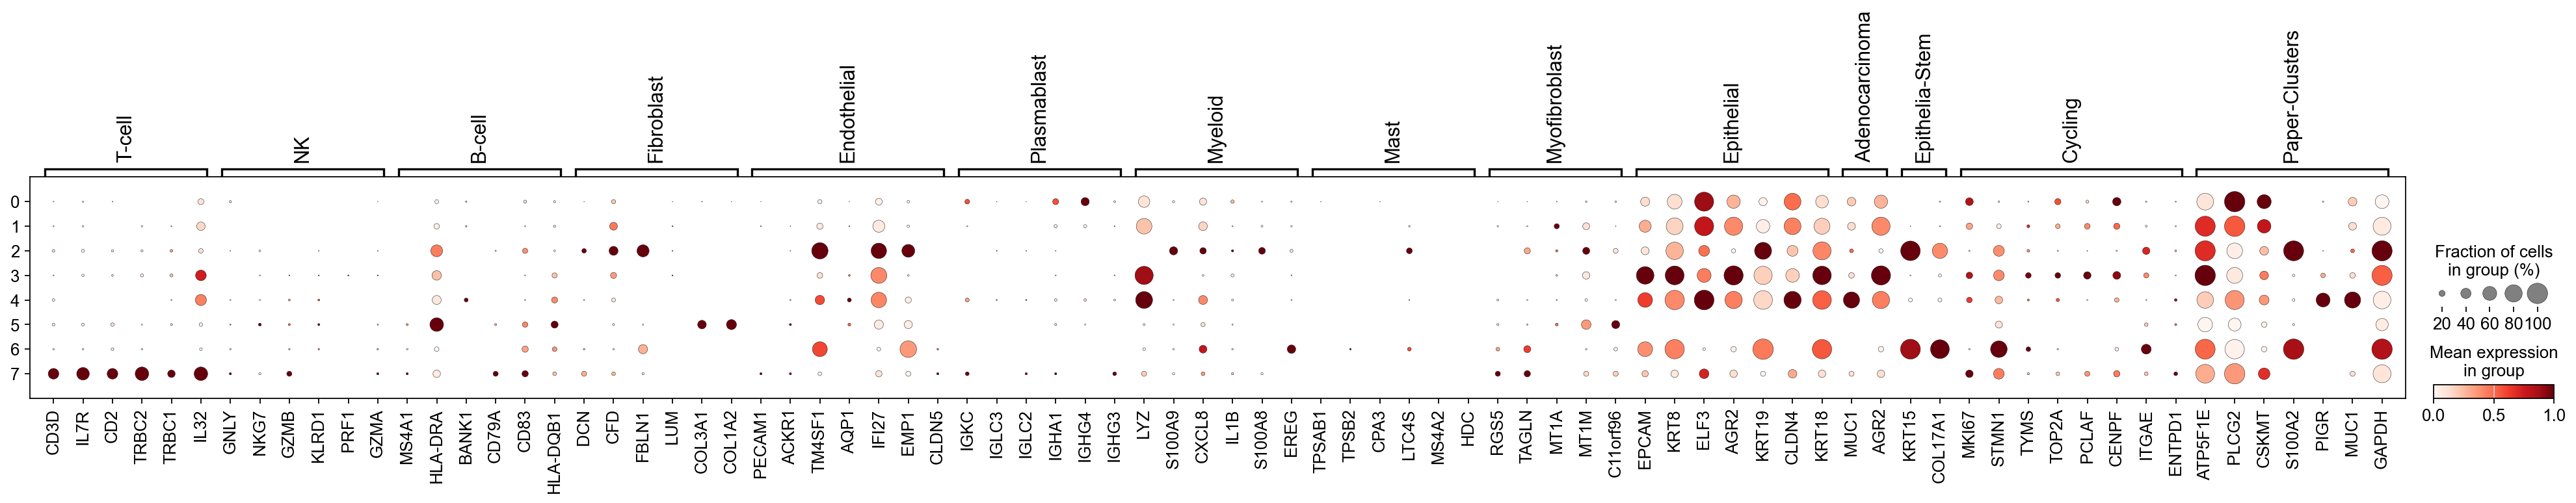

In [142]:
### Can vary my clustering resolution from here
sc.pl.dotplot(
    adata,
    groupby="leiden_res0_7",
    var_names=Cell_types,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

# Cluster-Specific DEG's as markers

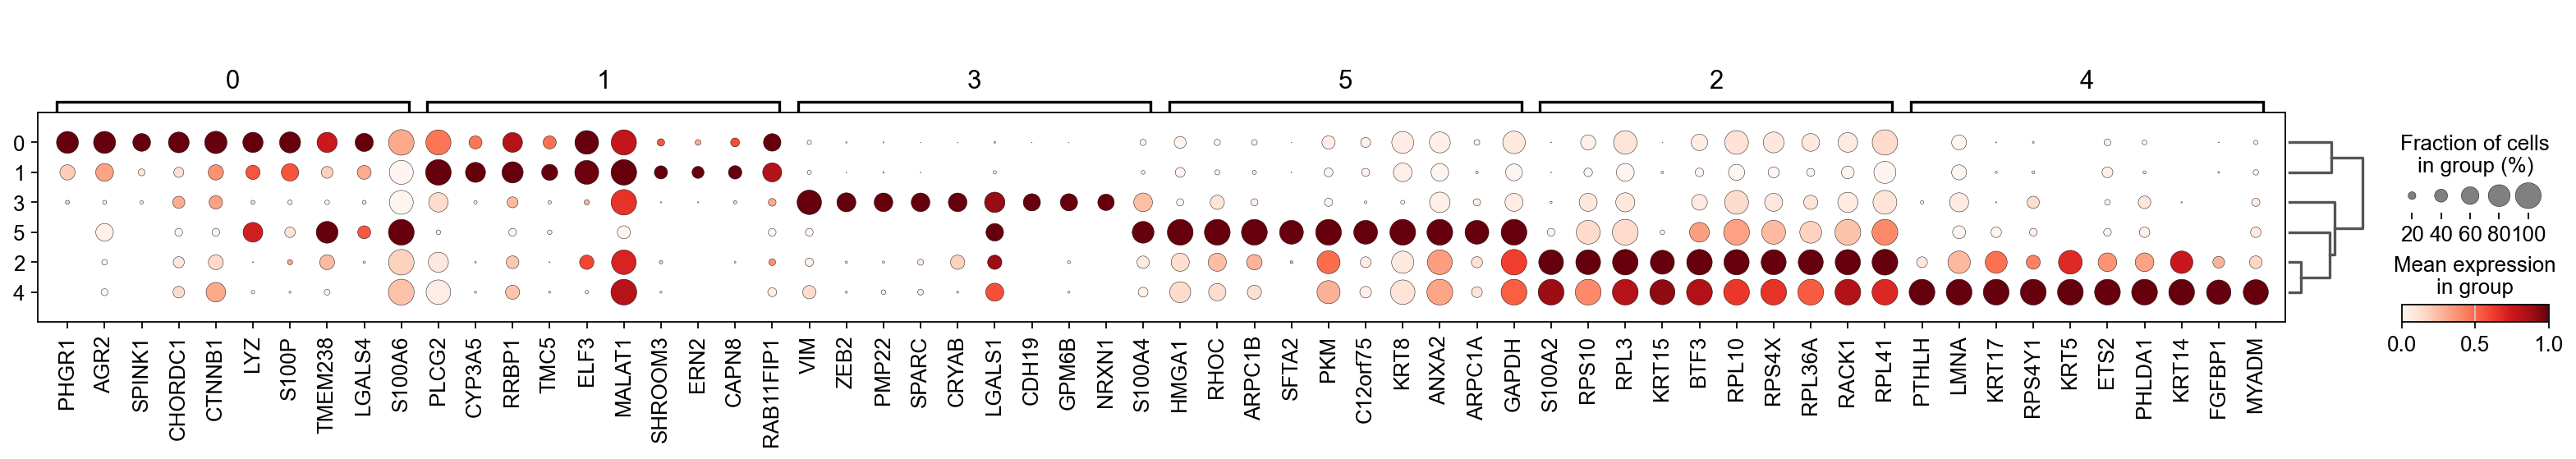

In [143]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden_res0_4", method="wilcoxon")

sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res0_4", standard_scale="var"
)

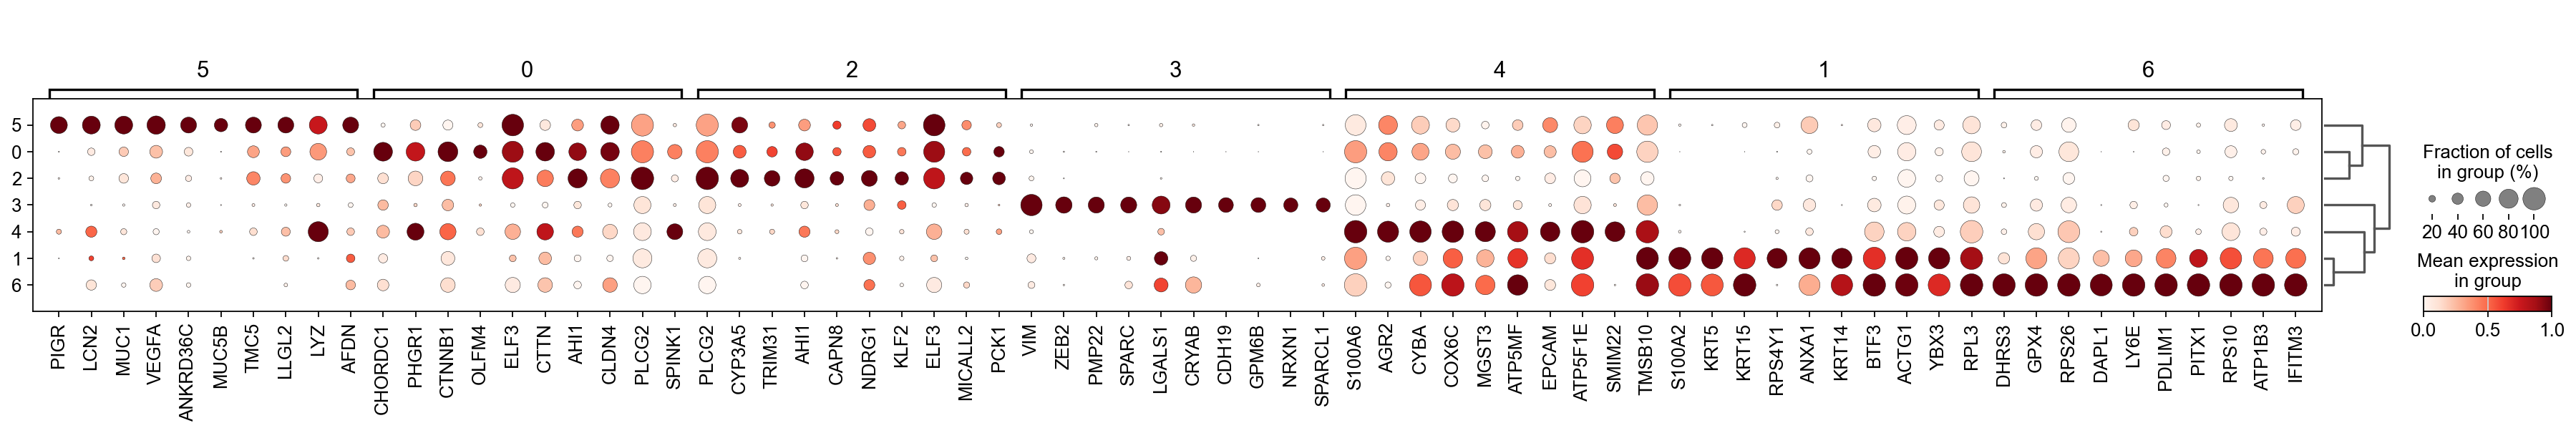

In [144]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden_res0_5", method="wilcoxon")

sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res0_5", standard_scale="var"
)

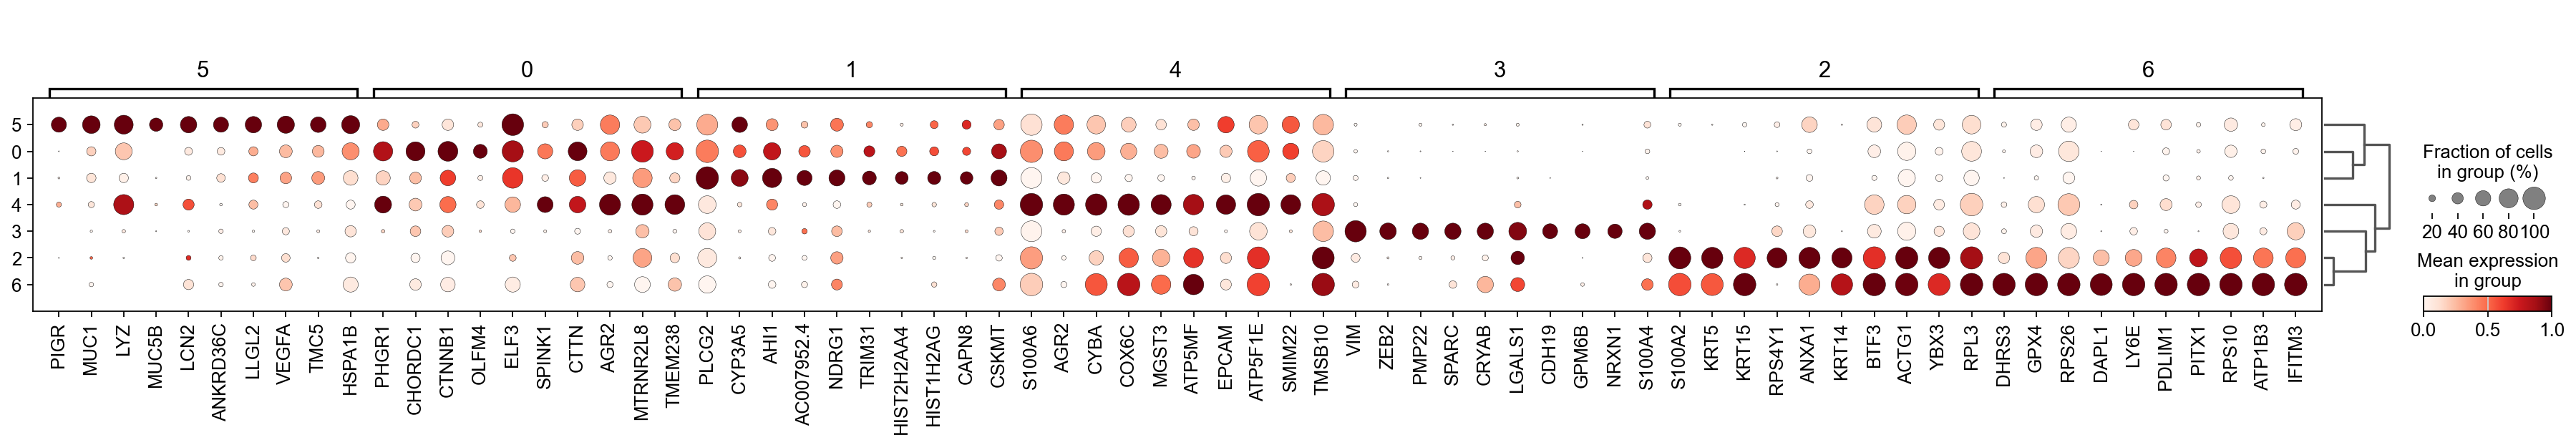

In [145]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden_res0_6", method="wilcoxon")

sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res0_6", standard_scale="var"
)

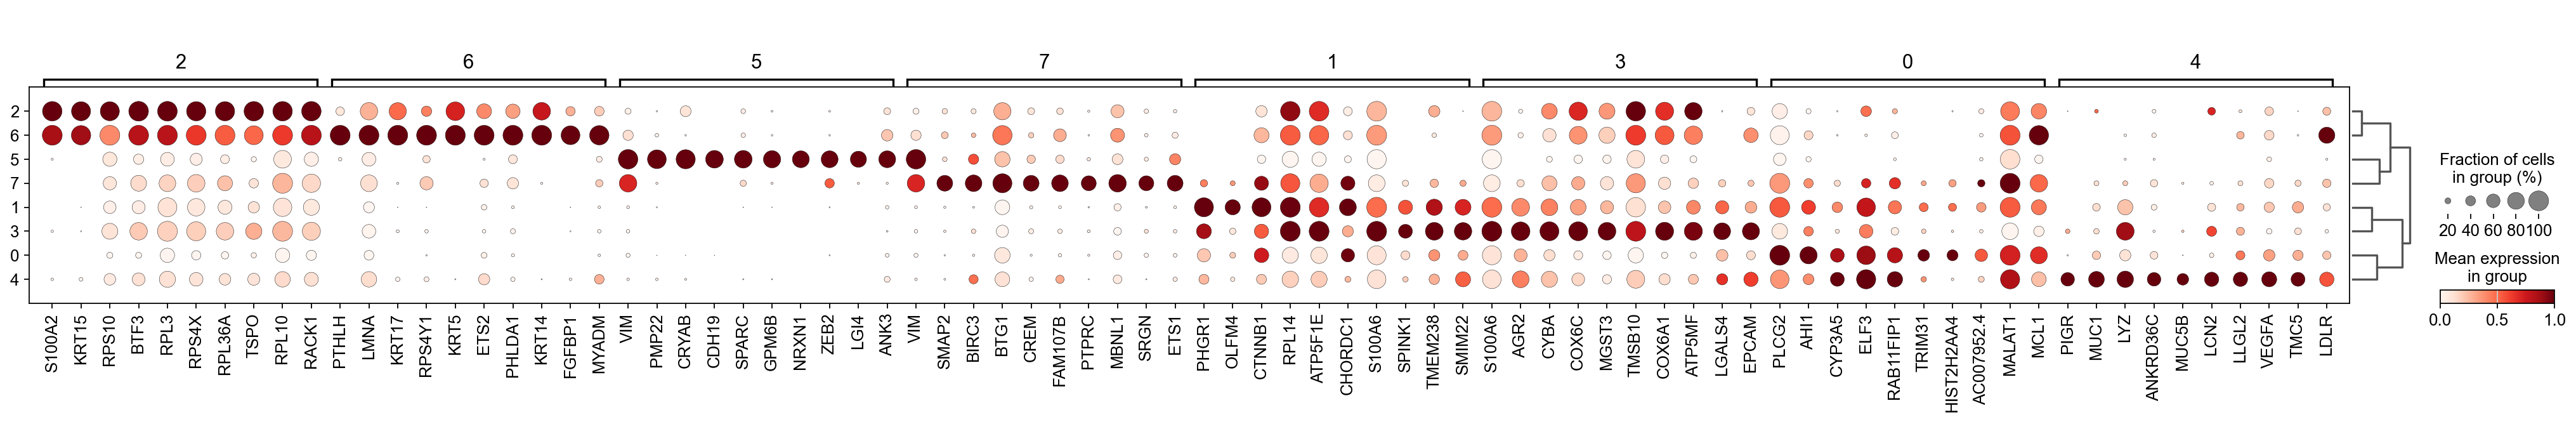

In [146]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden_res0_7", method="wilcoxon")

sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res0_7", standard_scale="var"
)

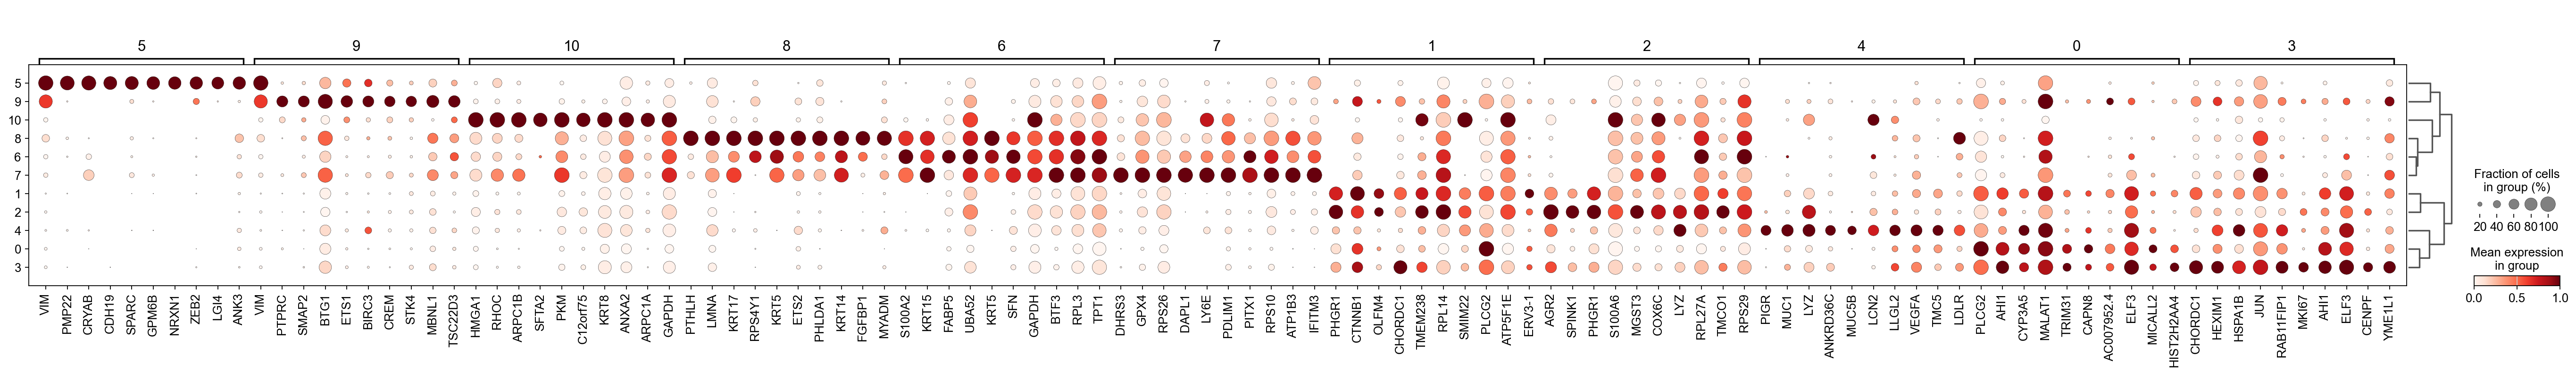

In [147]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden_res1", method="wilcoxon")

sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res1", standard_scale="var"
)

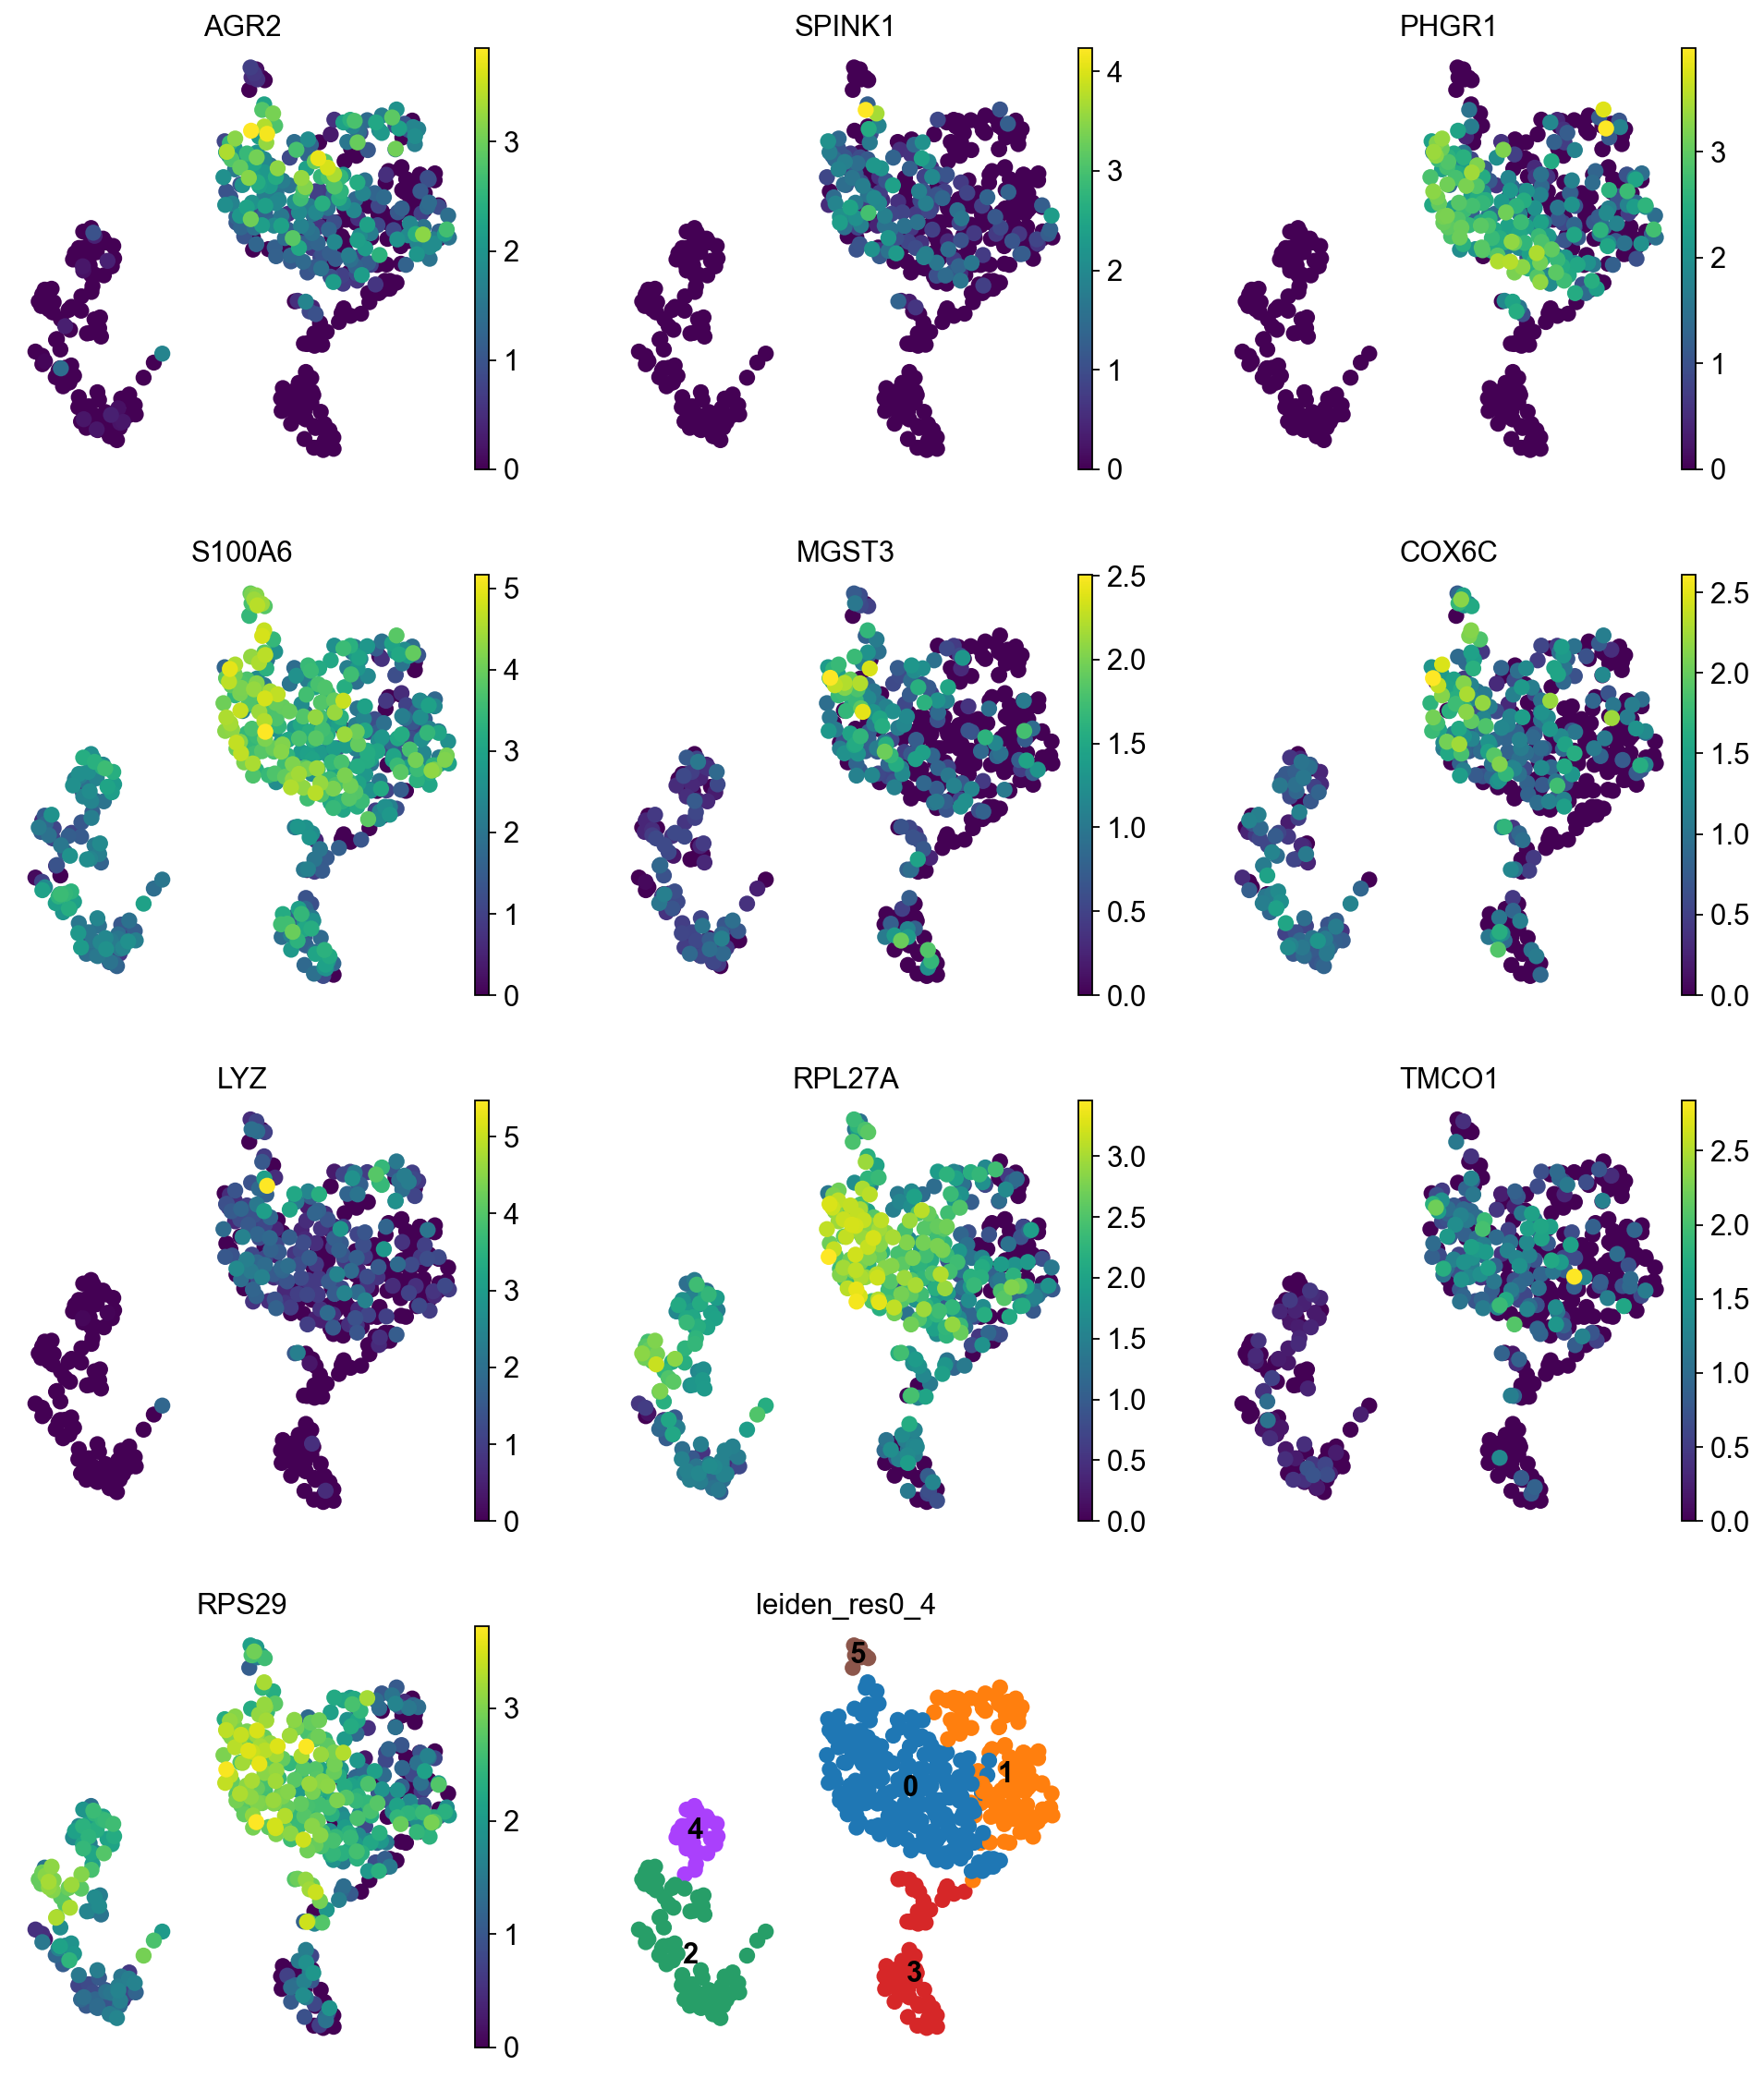

In [148]:
adata.X = adata.layers['log1p_norm']

dc_cluster_genes = sc.get.rank_genes_groups_df(adata, group="2").head(10)["names"]
sc.pl.umap(
    adata,
    color=[*dc_cluster_genes, "leiden_res0_4"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)

## Cell-typist

In [149]:
import celltypist
from celltypist import models

In [150]:
adata_celltypist = adata.copy()  # make a copy of our adata
adata_celltypist.X = adata.layers["counts"]  # set adata.X to raw counts
sc.pp.normalize_per_cell(
    adata_celltypist, counts_per_cell_after=10**4
)  # normalize to 10,000 counts per cell
sc.pp.log1p(adata_celltypist)  # log-transform
# make .X dense instead of sparse, for compatibility with celltypist:
adata_celltypist.X = adata_celltypist.X.toarray()

In [151]:
## This is cell typist immune cell models - potentially the only ones relevant to this analysis
models.download_models(
    force_update=True, model=["Immune_All_Low.pkl", "Immune_All_High.pkl"]
)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 54
📂 Storing models in /Users/alex/.celltypist/data/models
💾 Total models to download: 2
💾 Downloading model [1/2]: Immune_All_Low.pkl
💾 Downloading model [2/2]: Immune_All_High.pkl


In [152]:
#high level = coarses annotation, low = finer annotation
model_low = models.Model.load(model="Immune_All_Low.pkl")
model_high = models.Model.load(model="Immune_All_High.pkl")

In [153]:
predictions_high = celltypist.annotate(
    adata_celltypist, model=model_high, majority_voting=True
)
predictions_high_adata = predictions_high.to_adata()

🔬 Input data has 489 cells and 25815 genes
🔗 Matching reference genes in the model
🧬 5908 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


In [154]:
#copies results to original adata object
adata.obs["celltypist_cell_label_coarse"] = predictions_high_adata.obs.loc[
    adata.obs.index, "majority_voting"
]
adata.obs["celltypist_conf_score_coarse"] = predictions_high_adata.obs.loc[
    adata.obs.index, "conf_score"
]

In [155]:
predictions_low = celltypist.annotate(
    adata_celltypist, model=model_low, majority_voting=True
)

🔬 Input data has 489 cells and 25815 genes
🔗 Matching reference genes in the model
🧬 5908 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


In [156]:
predictions_low_adata = predictions_low.to_adata()

In [157]:
adata.obs["celltypist_cell_label_fine"] = predictions_low_adata.obs.loc[
    adata.obs.index, "majority_voting"
]
adata.obs["celltypist_conf_score_fine"] = predictions_low_adata.obs.loc[
    adata.obs.index, "conf_score"
]

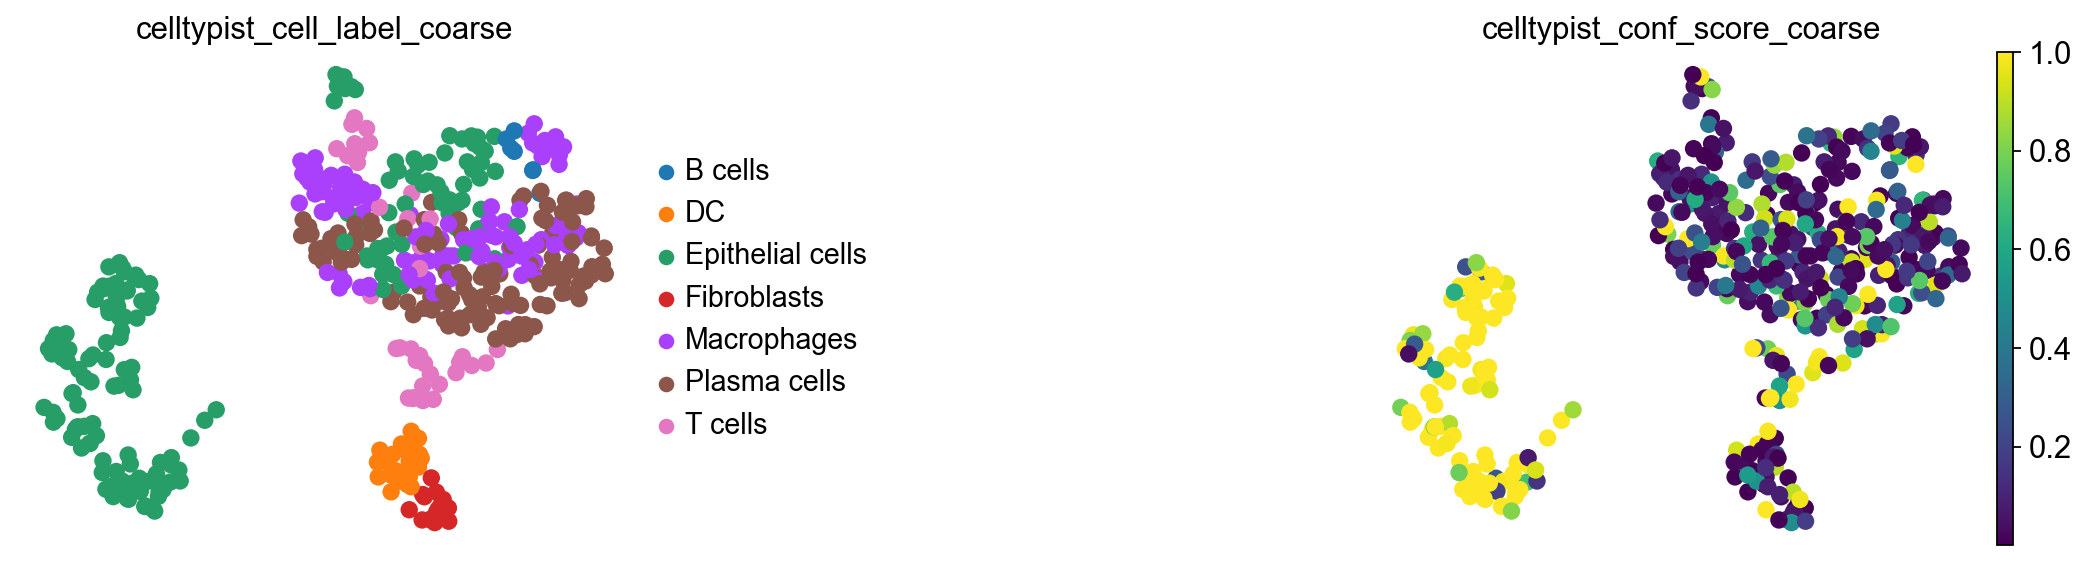

In [158]:
sc.pl.umap(
    adata,
    color=["celltypist_cell_label_coarse", "celltypist_conf_score_coarse"],
    frameon=False,
    sort_order=False,
    wspace=1,
)

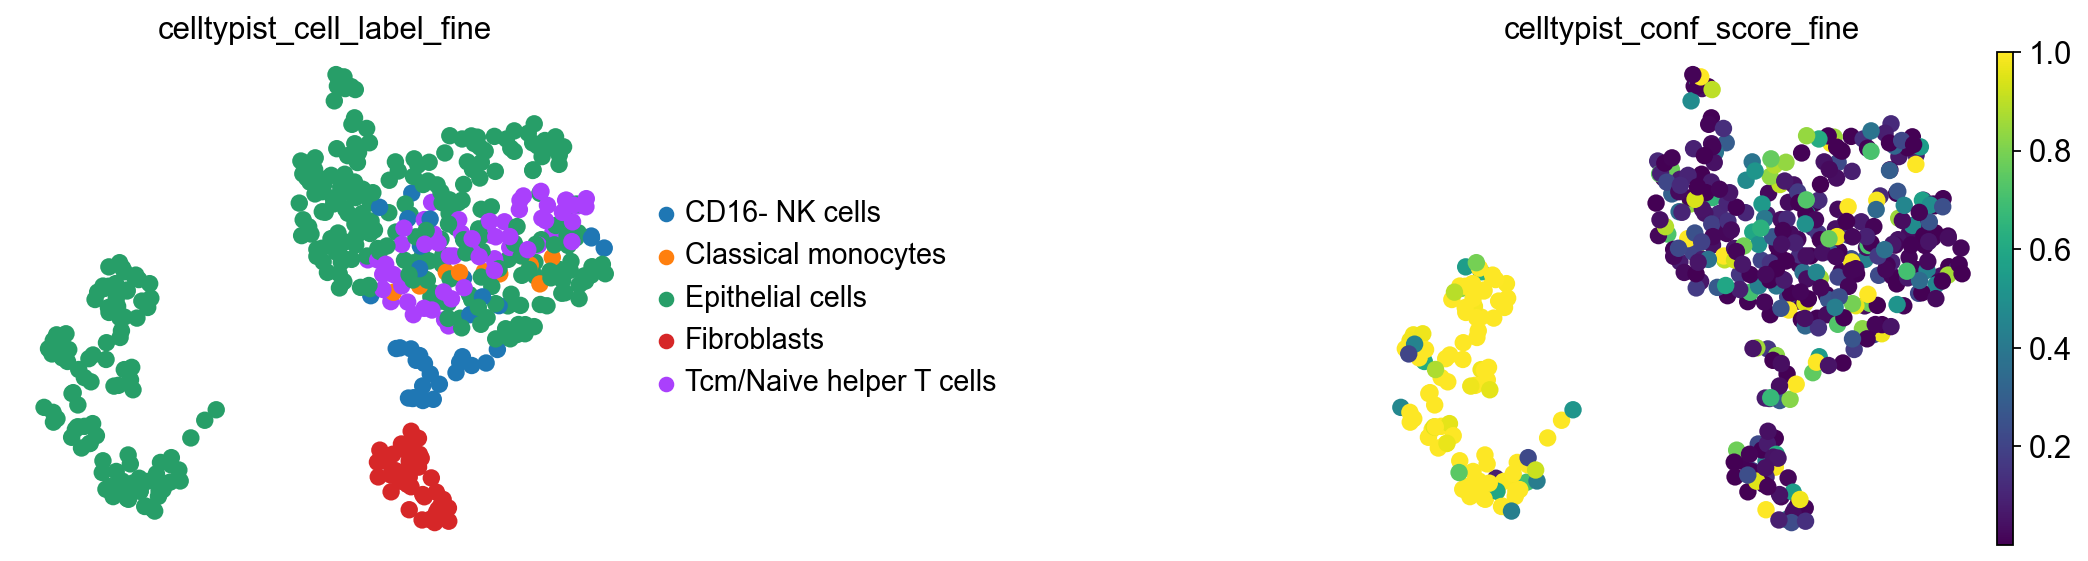

In [159]:
sc.pl.umap(
    adata,
    color=["celltypist_cell_label_fine", "celltypist_conf_score_fine"],
    frameon=False,
    sort_order=False,
    wspace=1,
)

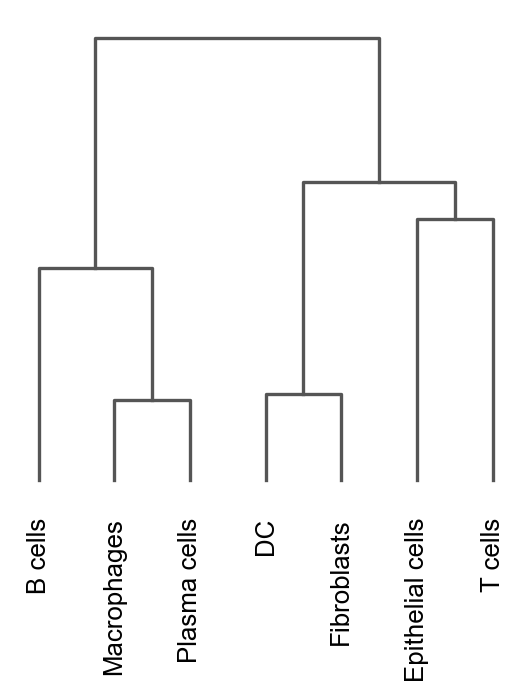

<Axes: >

In [160]:
sc.pl.dendrogram(adata, groupby="celltypist_cell_label_coarse")

In [161]:
pd.crosstab(adata.obs.leiden_res0_4, adata.obs.celltypist_cell_label_coarse)

celltypist_cell_label_coarse  B cells  DC  Epithelial cells  Fibroblasts  \
leiden_res0_4                                                              
0                                   0   0                42            0   
1                                   7   0                17            0   
2                                   0   0                77            0   
3                                   0  26                 0           15   
4                                   0   0                29            0   
5                                   0   0                10            0   

celltypist_cell_label_coarse  Macrophages  Plasma cells  T cells  
leiden_res0_4                                                     
0                                      71            78       17  
1                                      33            47        1  
2                                       0             0        0  
3                                       0             0       19  
4                                       0             0        0  
5                                       0             0        0

In [162]:
pd.crosstab(adata.obs.leiden_res0_4, adata.obs.celltypist_cell_label_fine)

celltypist_cell_label_fine  CD16- NK cells  Classical monocytes  \
leiden_res0_4                                                     
0                                       11                    5   
1                                        4                    4   
2                                        0                    0   
3                                       19                    0   
4                                        0                    0   
5                                        0                    0   

celltypist_cell_label_fine  Epithelial cells  Fibroblasts  \
leiden_res0_4                                               
0                                        148            0   
1                                         75            0   
2                                         77            0   
3                                          0           41   
4                                         29            0   
5                                         10            0   

celltypist_cell_label_fine  Tcm/Naive helper T cells  
leiden_res0_4                                         
0                                                 44  
1                                                 22  
2                                                  0  
3                                                  0  
4                                                  0  
5                                                  0

In [163]:
adata.obs

cell_ids  n_genes_by_counts  log1p_n_genes_by_counts  \
17      AAACGCTTCATCTACT.1_1               1169                 7.064759   
143     AACCATGTCGAATGCT.1_1               1740                 7.462215   
465     ACATCCCAGTGCAAAT.1_1               2069                 7.635304   
567     ACCGTTCTCCTATGGA.1_1                526                 6.267201   
1433    ATCGCCTTCCATACAG.1_1               2060                 7.630947   
...                      ...                ...                      ...   
49096  AGCCAATAGACATAGT.1_10               2215                 7.703459   
49446  ATTACCTTCGATCCCT.1_10               3402                 8.132413   
49849  CCCTTAGAGCTTCATG.1_10               2425                 7.793999   
50484  GACCAATGTATGGGAC.1_10               3407                 8.133881   
51278  GTTCGCTTCGGAGTGA.1_10               1169                 7.064759   

       total_counts  log1p_total_counts  pct_counts_in_top_20_genes  \
17      1781.981523            7.486042                   15.656233   
143     4589.532619            8.431751                   20.037812   
465     5470.088044            8.607233                   23.304426   
567      716.778287            6.576161                   16.913381   
1433    4836.789279            8.484213                   17.957565   
...             ...                 ...                         ...   
49096  11398.238326            9.341302                   26.566625   
49446  43689.400547           10.684884                   55.188501   
49849  46149.419943           10.739661                   58.640037   
50484  21167.510738            9.960270                   25.615430   
51278   3217.530894            8.076680                   18.945897   

       total_counts_mt  log1p_total_counts_mt  pct_counts_mt  \
17           56.618673               4.053847       3.177287   
143         186.447027               5.233496       4.062440   
465         162.756366               5.098380       2.975388   
567          27.446549               3.348027       3.829155   
1433        114.194623               4.746623       2.360959   
...                ...                    ...            ...   
49096       950.775574               6.858329       8.341426   
49446       630.014400               6.447329       1.442030   
49849       416.663218               6.034675       0.902857   
50484      2031.537961               7.617041       9.597434   
51278       213.969857               5.370498       6.650126   

       total_counts_ribo  ...  leiden_res0_5  leiden_res0_6  leiden_res0_7  \
17             71.488478  ...              3              3              5   
143          1109.287658  ...              3              3              5   
465          1101.793021  ...              3              3              7   
567            40.918374  ...              3              3              5   
1433          838.557077  ...              3              3              5   
...                  ...  ...            ...            ...            ...   
49096        5462.570586  ...              1              2              2   
49446        1059.849960  ...              1              2              2   
49849         521.818183  ...              1              2              2   
50484        7739.621151  ...              1              2              2   
51278        1113.210163  ...              3              3              7   

       leiden_res1  tumoural  subclone celltypist_cell_label_coarse  \
17               5     tumor         1                  Fibroblasts   
143              5     tumor         1                           DC   
465              9     tumor         1                      T cells   
567              5  filtered       NaN                  Fibroblasts   
1433             5     tumor         1                           DC   
...            ...       ...       ...                          ...   
49096            6    normal       NaN             

In [164]:
adata.obs['celltypist_cell_label_coarse'].value_counts()

Epithelial cells    175
Plasma cells        125
Macrophages         104
T cells              37
DC                   26
Fibroblasts          15
B cells               7
Name: celltypist_cell_label_coarse, dtype: int64

In [165]:
adata.obs['celltypist_cell_label_fine'].value_counts()

Epithelial cells            339
Tcm/Naive helper T cells     66
Fibroblasts                  41
CD16- NK cells               34
Classical monocytes           9
Name: celltypist_cell_label_fine, dtype: int64

# Write current progress

In [166]:
adata.write("epi_adata.h5ad")